In [1]:
%load_ext autoreload
%autoreload 

import sys, os
sys.path.append(os.path.abspath(".."))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


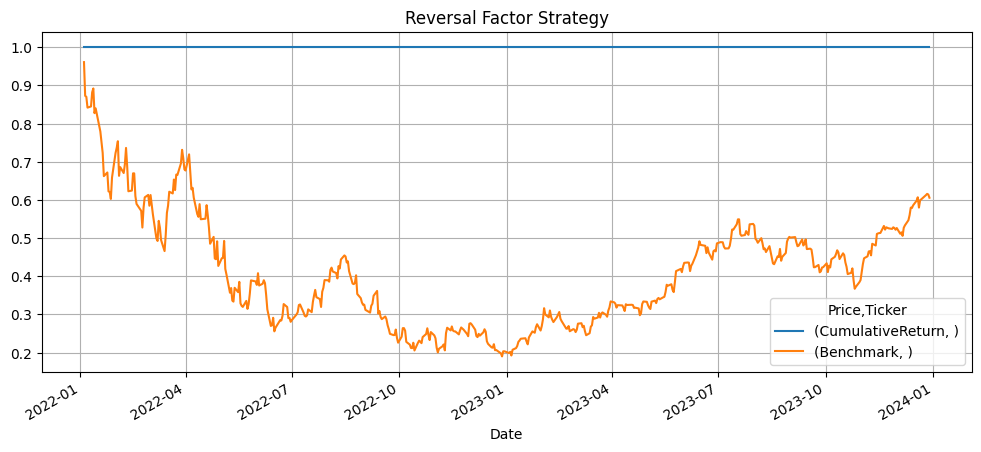

{'年化收益': np.float64(0.0), '年化波动': np.float64(0.0), '夏普比率': nan, '最大回撤': np.float64(0.0)}


In [2]:
# 02_factor_test.ipynb
# 目标：构造反转因子 + 构建择时信号 + 回测效果

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import sys, os

# sys.path.append(os.path.abspath("../utils"))
from utils.backtest import simple_backtest
from utils.evaluate import evaluate_strategy

# 下载数据
df = yf.download("TQQQ", start="2022-01-01", end="2023-12-31")
df = df[["Close"]]

# 构造反转因子（过去 5 天涨幅的负值）
df["Ret_5"] = df["Close"].pct_change(5)
df["RevFactor"] = -df["Ret_5"]

# 滚动分位打分，取近 60 天的分位数（低分买入，高分卖出）
df["Quantile"] = df["RevFactor"].rolling(60).apply(
    lambda x: pd.qcut(x, 5, labels=False)[-1] if len(x.dropna()) == 5 else np.nan,
    raw=False
)

# 构建信号：低分买入，高分卖出
df["Signal"] = 0
df.loc[df["Quantile"] == 0, "Signal"] = 1
df.loc[df["Quantile"] == 4, "Signal"] = -1

# 去除重复信号
df["CleanSignal"] = df["Signal"]
df["CleanSignal"] = df["CleanSignal"].mask(df["CleanSignal"] == df["CleanSignal"].shift(1))

# 回测
df_bt = simple_backtest(df, signal_col="CleanSignal", fee=0.001)

# 添加 benchmark
df_bt["Benchmark"] = (1 + df_bt["Return"]).cumprod()

# 可视化
df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="Reversal Factor Strategy")
plt.grid(True)
plt.show()

# 打印指标
print(evaluate_strategy(df_bt))


In [3]:
from utils.factor_tools import compute_reversal_factor, compute_volatility_factor, generate_signal_by_quantile


# 因子构造
df["Reversal"] = compute_reversal_factor(df, window=5)
df["Volatility"] = compute_volatility_factor(df, window=5)

# 因子合成（反转 - 波动）
df["CombinedFactor"] = df["Reversal"] - df["Volatility"]


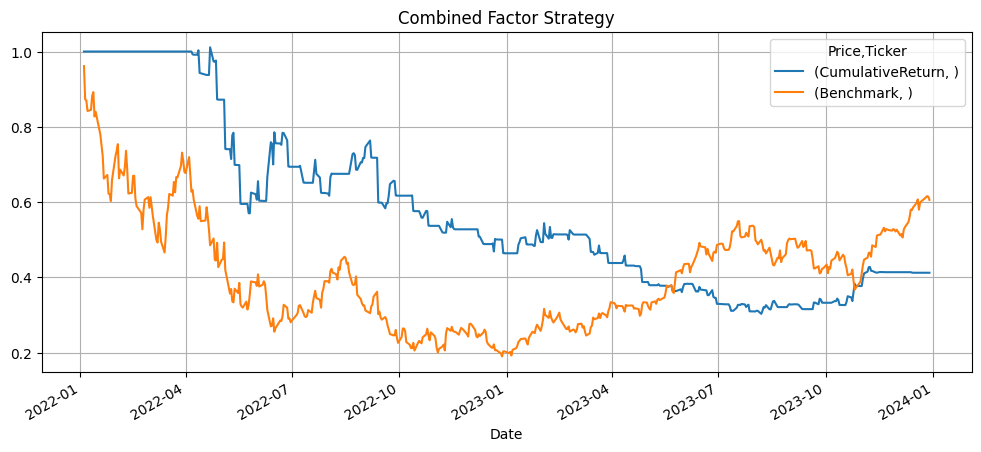

{'年化收益': np.float64(-0.3442), '年化波动': np.float64(0.4492), '夏普比率': np.float64(-0.7662), '最大回撤': np.float64(-0.7005)}


In [4]:
# 信号生成（按 CombinedFactor 分位打分）
df = generate_signal_by_quantile(df, factor_col="CombinedFactor", n_quantiles=5)

# 去除重复信号
df["CleanSignal"] = df["Signal"]
df["CleanSignal"] = df["CleanSignal"].mask(df["CleanSignal"] == df["CleanSignal"].shift(1))

# 回测
df_bt = simple_backtest(df, signal_col="CleanSignal", fee=0.001)

# 评估
df_bt["Benchmark"] = (1 + df_bt["Return"]).cumprod()
df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="Combined Factor Strategy")
plt.grid(True)
plt.show()

print(evaluate_strategy(df_bt))

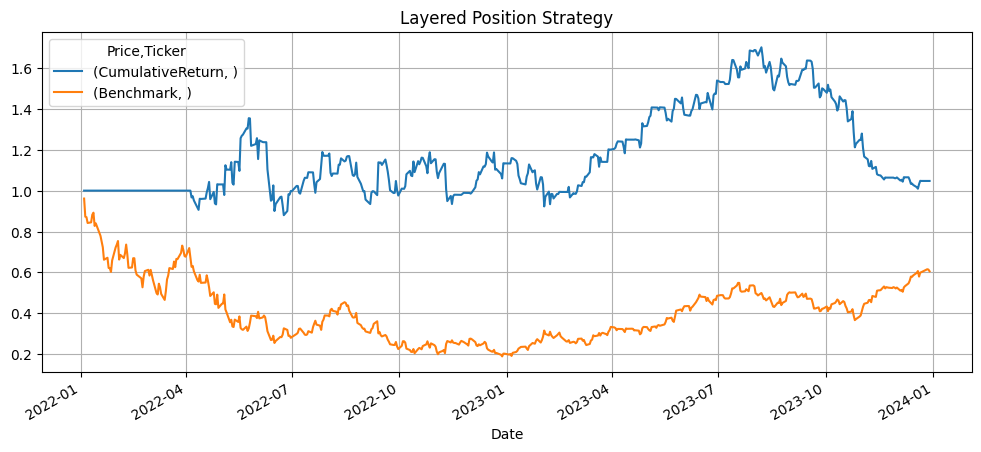

{'年化收益': np.float64(0.149), '年化波动': np.float64(0.5025), '夏普比率': np.float64(0.2966), '最大回撤': np.float64(-0.4065)}


In [5]:
from utils.position_tools import generate_layered_position

# 使用组合因子生成分层仓位
df["Position"] = generate_layered_position(df, factor_col="CombinedFactor", n_layers=5)

# 回测（不需要信号打分）
df["Signal"] = df["Position"]           # 兼容 simple_backtest 接口
df["CleanSignal"] = df["Signal"]
df["CleanSignal"] = df["CleanSignal"].mask(df["CleanSignal"] == df["CleanSignal"].shift(1))

df_bt = simple_backtest(df, signal_col="CleanSignal", fee=0.001)

df_bt["Benchmark"] = (1 + df_bt["Return"]).cumprod()
df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="Layered Position Strategy")
plt.grid(True)
plt.show()

print(evaluate_strategy(df_bt))


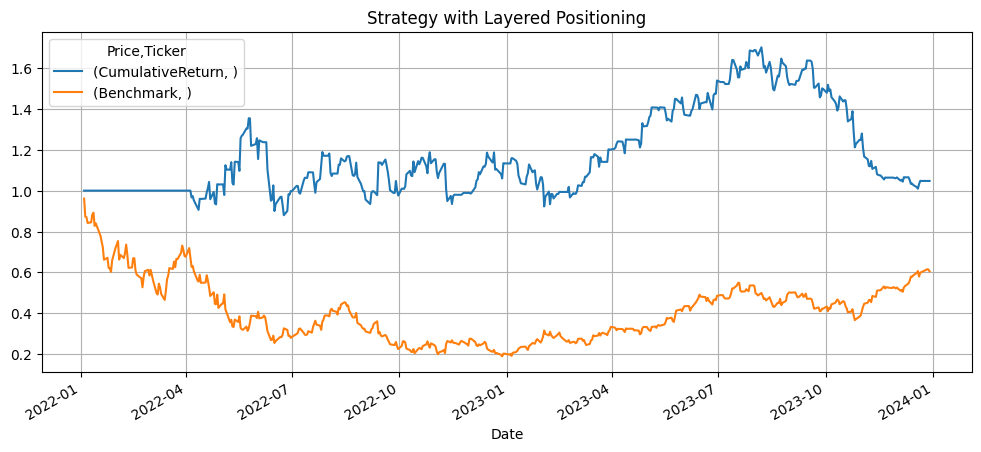

{'年化收益': np.float64(0.149), '年化波动': np.float64(0.5025), '夏普比率': np.float64(0.2966), '最大回撤': np.float64(-0.4065)}


In [6]:
from utils.strategy_runner import run_strategy_pipeline

# run_strategy_pipeline 会帮你自动处理 Signal → CleanSignal → 回测
df_bt = run_strategy_pipeline(df, position_col="Position", fee=0.001)

# 可视化
df_bt[["CumulativeReturn", "Benchmark"]].plot(figsize=(12, 5), title="Strategy with Layered Positioning")
plt.grid(True)
plt.show()

# 输出指标
print(evaluate_strategy(df_bt))


In [7]:
from utils.strategy_runner import save_strategy_result

metrics = evaluate_strategy(df_bt)
save_strategy_result(df_bt, metrics, output_dir="./results", strategy_name="reversal_vol_layered")


[Saved] ./results/reversal_vol_layered_equity.csv
[Saved] ./results/reversal_vol_layered_metrics.csv
